# Naive Bayes

<b>necessary imports </b>

In [1]:
import pandas as pd 
import pickle
import numpy as np 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model  import Ridge,Lasso,RidgeCV, LassoCV, ElasticNet, ElasticNetCV, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
#import scikitp#lot as skl
sns.set()

In [2]:
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
data.shape

(768, 9)

In [4]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
data.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [6]:
columns = list(data.columns)

In [7]:
columns[1:-2]

['Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction']

In [8]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

# First basic model with basic imputation

In [9]:
data_1 = data.copy()
data_1.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


In [10]:
data_1.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [11]:
for col in data_1.columns:
    print(f'{col}:{data_1[data_1[col]==0][col].count()}')

Pregnancies:111
Glucose:5
BloodPressure:35
SkinThickness:227
Insulin:374
BMI:11
DiabetesPedigreeFunction:0
Age:0
Outcome:500


<b>The following columns have 0 values which need to be replaced with NaN because 0 doesnt seem to appropriate value for this feature</b>

In [12]:
fill_Nan_columns = ['Glucose','BloodPressure','SkinThickness',
                    'Insulin','BMI']
data_1[fill_Nan_columns] = data_1[fill_Nan_columns].replace(0,np.nan)

In [13]:
data_1.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [14]:
data_corr  = data_1[['SkinThickness','BMI']]

<AxesSubplot:>

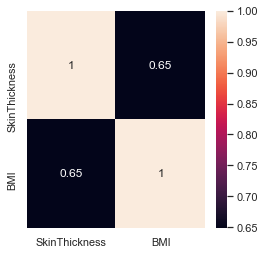

In [15]:
corr = data_corr.corr()
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 4,4
sns.heatmap(corr, xticklabels = corr.columns, annot = True, yticklabels = corr.columns)

In [16]:
data_imputed = data_1[fill_Nan_columns]
data_imputed.isnull().sum()

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
def impute_data(data_1,fill_Nan_columns):
    #create smller dataframe of columns with nan values
    data_imputed = data_1[fill_Nan_columns]
    #filling BMI with mean bcoz it has just 11 nan values. The aim is to use BMI to predict the nan values of skinthickness
    #we checked before that BMI snd skinthikcness have high corrleation
    data_imputed['BMI'] = data_imputed['BMI'].fillna(data_1['BMI'].mean())
    #extracting only non nan rows of skinthickness to train our model
    #SkinThickness_train = pd.DataFrame(data_imputed[data_imputed['SkinThickness'] != np.nan].SkinThickness)
    SkinThickness_train = pd.DataFrame(data_imputed.loc[pd.notnull(data_imputed.SkinThickness)]['SkinThickness'])
    #extracting only those rows of BMI where skinthickness is not null to train our model
    BMI_train = pd.DataFrame(data_imputed.loc[pd.notnull(data_imputed.SkinThickness)]['BMI'])
    #training our model and fitting
    lm = LinearRegression()
    lm.fit(BMI_train,SkinThickness_train)
    #for predicting passing only BMI values of rows in which skinthickness is null
    BMI_test = pd.DataFrame(data_imputed.loc[pd.isnull(data_imputed.SkinThickness)]['BMI'])
    SkinThickness_test = lm.predict(BMI_test)  
    #copying the original index so we can merge it later
    SkinThickness_test_df = pd.DataFrame(data = SkinThickness_test, columns = ['SkinThickness'], index = BMI_test.index.copy())
    #merging the text result into the data_imputed dataframe
    data_imputed = pd.merge(data_imputed, SkinThickness_test_df, how = 'left', left_index = True, right_index = True) 
    #_y and _x results in this process so now fill na with the predicted result
    data_imputed["SkinThickness_y"] = data_imputed["SkinThickness_y"].fillna(data_imputed["SkinThickness_x"])  
    #dropping _x column from data was imputed from and renaming _y to skinthickness
    data_imputed = data_imputed.drop('SkinThickness_x', axis=1)        
    data_imputed = data_imputed.rename(columns={'SkinThickness_y':'SkinThickness'})  
    
    #Glucose imputation with mean
    data_imputed['Glucose'] = data_imputed['Glucose'].replace(0,data_imputed['Glucose'].mean())
    #interative imputer - imputes insulin and bloodpressure        
    imp = IterativeImputer(max_iter=100, verbose=0)
    imp.fit(data_imputed)
    imputed_data = imp.transform(data_imputed)
    data_imputed = pd.DataFrame(imputed_data, columns=data_imputed.columns)
      
    #merging it with the original dataframe    
    data_1[fill_Nan_columns] =  data_imputed
    # or we can do with pd.concat([data_imputed, data_1], axis=1) and drop the repeating column
    
    with open('regression_imputer.sav', 'wb') as f:
          pickle.dump(lm,f)
    
    with open('Imperativeimputer.sav', 'wb') as f:
         pickle.dump(imp,f) 
                                               
    return data_1

In [18]:
data_1 = impute_data(data_1,fill_Nan_columns)

C:\Users\ayonh\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [19]:
data_1.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [20]:
X1 = data_1.drop('Outcome', axis=1)
y1 = data_1['Outcome']

In [21]:
X1.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,212.366667,33.6,35.0,0.627,50
1,1,85.0,66.0,66.484166,26.6,29.0,0.351,31


In [22]:
X1.dtypes,y1.dtypes

(Pregnancies                   int64
 Glucose                     float64
 BloodPressure               float64
 SkinThickness               float64
 Insulin                     float64
 BMI                         float64
 DiabetesPedigreeFunction    float64
 Age                           int64
 dtype: object,
 dtype('int64'))

In [23]:
scalar = StandardScaler()
X_scaled = scalar.fit_transform(X1)
X_scaled

array([[ 0.63994726,  0.8657499 , -0.03191523, ...,  0.65813331,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.20391783, -0.526958  , ...,  0.02921563,
        -0.36506078, -0.19067191],
       [ 1.23388019,  2.01556531, -0.69197225, ..., -0.94997531,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 , -0.02125055, -0.03191523, ..., -0.59970206,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.14300879, -1.02200076, ..., -0.24455814,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.94110288, -0.19692949, ...,  0.23885486,
        -0.47378505, -0.87137393]])

In [24]:
# now we will check for multicollinearity using VIF(Variance Inflation factor)
vif = pd.DataFrame()
vif["vif"] = [variance_inflation_factor(X_scaled,i) for i in range(X_scaled.shape[1])]
vif["Features"] = X1.columns

#let's check the values
vif

,vif,Features
0,1.433383,Pregnancies
1,2.090323,Glucose
2,1.260868,BloodPressure
3,2.033638,SkinThickness
4,2.231364,Insulin
5,2.068863,BMI
6,1.045918,DiabetesPedigreeFunction
7,1.613810,Age


<b>All the VIF values are less than 5 and are very low. That means no multicollinearity. Now, we can go ahead with fitting our data to the model. Before that, lets split our data in test and training set.</b>

In [25]:
from sklearn.model_selection import train_test_split
train_x1,test_x1,train_y1,test_y1=train_test_split(X_scaled,y1,test_size=0.3,random_state=42)

In [26]:
from sklearn.naive_bayes import GaussianNB
NB_model = GaussianNB()

In [27]:
NB_model.fit(train_x1,train_y1)

GaussianNB()

In [28]:
import pickle
# Writing different model files to file
with open( 'modelForPrediction.sav', 'wb') as f:
    pickle.dump(NB_model,f)
    
with open('standardScalar.sav', 'wb') as f:
    pickle.dump(scalar,f)   
    
    

In [29]:
loaded_model = pickle.load(open('modelForPrediction.sav', 'rb'))

In [30]:
scaler_transform = pickle.load(open('standardScalar.sav', 'rb'))

In [31]:
y_pred = loaded_model.predict(test_x1)

In [32]:
print(accuracy_score(test_y1, y_pred))

0.7272727272727273


In [33]:
test_set1 = data.iloc[:50,].reset_index(drop=True)
test_set2 = data.iloc[51:100,].reset_index(drop=True)
test_set3 = data.iloc[101:150,].reset_index(drop=True)

In [34]:
test_set1.to_csv('test_set1.csv')
test_set2.to_csv('test_set2.csv')
test_set3.to_csv('test_set3.csv')

In [35]:
test_set3.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,151,60,0,0,26.1,0.179,22,0
1,0,125,96,0,0,22.5,0.262,21,0
2,1,81,72,18,40,26.6,0.283,24,0


In [36]:
class batch_data_prep:
    def __init__(self ,dataframe):
        self.dataframe = dataframe
        

    def nan_feature(self, dataframe):
        columns = list(dataframe.columns)
        fill_Nan_columns = columns[1:-2]
        dataframe[fill_Nan_columns] = dataframe[fill_Nan_columns].replace(0,np.nan)
        df_to_impute = dataframe[fill_Nan_columns]
        return df_to_impute


    def impute_data(self, dataframe, df_to_impute):
    
        df_to_impute['BMI'] = df_to_impute['BMI'].fillna(dataframe['BMI'].mean())
        BMI_test = pd.DataFrame(df_to_impute.loc[pd.isnull(df_to_impute.SkinThickness)]['BMI'])
        
        LM = pickle.load(open('regression_imputer.sav', 'rb'))
        SkinThickness_test = LM.predict(BMI_test) 

        SkinThickness_test_df = pd.DataFrame(data = SkinThickness_test, columns = ['SkinThickness'], index = BMI_test.index.copy())
        df_to_impute = pd.merge(df_to_impute, SkinThickness_test_df, how = 'left', left_index = True, right_index = True) 
        df_to_impute["SkinThickness_y"] = df_to_impute["SkinThickness_y"].fillna(df_to_impute["SkinThickness_x"])
        df_to_impute = df_to_impute.drop('SkinThickness_x', axis=1)        
        df_to_impute = df_to_impute.rename(columns={'SkinThickness_y':'SkinThickness'}) 
        df_to_impute['Glucose'] = df_to_impute['Glucose'].replace(0,df_to_impute['Glucose'].mean())
  
        from sklearn.experimental import enable_iterative_imputer
        from sklearn.impute import IterativeImputer
        imp = IterativeImputer(max_iter=100, verbose=0)
        imp.fit(df_to_impute)
        imputed_data = imp.transform(df_to_impute)
        df_to_impute = pd.DataFrame(imputed_data, columns=df_to_impute.columns)
        df_to_impute = df_to_impute[['Glucose', 'BloodPressure', 'SkinThickness','Insulin', 'BMI', 'DiabetesPedigreeFunction']]
        #dataframe[[fill_Nan_columns]] =  df_to_impute
        return df_to_impute

    def scaler_transform(self,dataframe):
        scaler_transform = pickle.load(open('standardScalar.sav', 'rb'))
        tranformed_array = scalar.transform(dataframe)
        tranformed_dataframe = pd.DataFrame(tranformed_array, columns = dataframe.columns)
        return tranformed_dataframe

In [37]:
batch_test = pd.read_csv('test_set1.csv')
batch_test = batch_test.drop('Unnamed: 0', axis=1)
batch_test.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [38]:
batch_test.shape

(50, 9)

In [39]:
batch_data_prep_object = batch_data_prep(batch_test)
dataframe_to_impute = batch_data_prep_object.nan_feature(batch_test)
dataframe_to_impute.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction
0,148,72.0,35.0,NaN,33.6,0.627
1,85,66.0,29.0,NaN,26.6,0.351
2,183,64.0,NaN,NaN,23.3,0.672
3,89,66.0,23.0,94.0,28.1,0.167
4,137,40.0,35.0,168.0,43.1,2.288


In [40]:
dataframe_to_impute.shape

(50, 6)

In [41]:
['Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction']

['Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction']

In [42]:
imputed_dataframe = batch_data_prep_object.impute_data(batch_test,dataframe_to_impute)
imputed_dataframe.head()

C:\Users\ayonh\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction
0,148.0,72.0,35.000000,251.369617,33.6,0.627
1,85.0,66.0,29.000000,75.724518,26.6,0.351
2,183.0,64.0,19.658323,343.411073,23.3,0.672
3,89.0,66.0,23.000000,94.000000,28.1,0.167
4,137.0,40.0,35.000000,168.000000,43.1,2.288


In [43]:
batch_test[['Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction']] = imputed_dataframe
batch_test.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,251.369617,33.6,0.627,50,1
1,1,85.0,66.0,29.0,75.724518,26.6,0.351,31,0


In [44]:
batch_test.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [45]:
for col in batch_test.columns:
    print(f'{col}:{batch_test[batch_test[col]==0][col].count()}')

Pregnancies:3
Glucose:0
BloodPressure:0
SkinThickness:0
Insulin:0
BMI:0
DiabetesPedigreeFunction:0
Age:0
Outcome:25


In [47]:
X = batch_test.drop(['Outcome'], axis=1)
y = batch_test['Outcome']
scaler_transformed_dataframe = batch_data_prep_object.scaler_transform(X)
scaler_transformed_dataframe.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.865750,-0.031915,-1.200307,31.861817,0.511386,0.468492,1.425995
1,-0.844885,-1.203918,-0.526958,-1.261972,6.297352,-0.222351,-0.365061,-0.190672
2,1.233880,2.015565,-0.691972,-1.357982,45.258095,-0.568256,0.604397,-0.105584


In [48]:
loaded_model = pickle.load(open('modelForPrediction.sav', 'rb'))
y_pred = loaded_model.predict(scaler_transformed_dataframe)
y_pred
print(accuracy_score(y, y_pred))

0.54


In [49]:
columns = X.columns
columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [50]:
fill_na = [i for i in columns if i not in 'Pregnancies']
fill_na

['Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']